In [85]:
import os, glob, codecs
import json
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

In [86]:
# Calculate CER
def symbols_calc_old_version(all_files): 
    symbols = {}
    words = {}
    for file_id, filename in enumerate(all_files):                    # We access each Json file (with a specific word details in it)

        with codecs.open(filename,'r', encoding="utf-8") as df:       # This way we read that Json file
            data = json.load(df)
            description = data['description']                         # and extract "description" key in it, which holds annotation form of that word
            predicted = data['moderation']['predicted']               # here, we extract "predicted" key in it, which holds the predicted form(output from HWR model) that word
            predicted_copy = predicted
        #print(file_id, filename, description, '-', predicted)
        j = 0
        k = 0
        correct_chars_sum = 0
        for i, ch in enumerate(description):                          # within this cycle, we assign a "{'freq': 1, 'pred': 0}" sub-directory for each character in an annotated form of word 
            if not ch in symbols:
                symbols[ch] = {'freq': 1, 'pred': 0}
            else:
                symbols[ch]['freq'] += 1                              # and find frequency for each of those characters in that word (i.e. just how many times does a certain character occur within a word)
        
            try:
                if ch == predicted[j]:
                    symbols[ch]['pred'] += 1
                    correct_chars_sum += 1
                    predicted_copy = predicted_copy[:j-k] + predicted_copy[j-k+1:]
                    k += 1
                    j += 1
                else:
                    if ch == predicted[j+1]:
                        symbols[ch]['pred'] += 1
                        correct_chars_sum += 1
                        predicted_copy = predicted_copy[:j-k+1] + predicted_copy[j-k+2:]
                        k += 1
                        j += 2
                    elif ch == predicted[j+2]:
                        symbols[ch]['pred'] += 1
                        correct_chars_sum += 1
                        predicted_copy = predicted_copy[:j-k+2] + predicted_copy[j-k+3:]
                        k += 1
                        j += 3
                    else:
                        #print(ch)
                        pass
            except:
                #print("Out of index")
                pass

        for ex_ch in predicted_copy:                                  # this cycle is to find which characters (in the predicted form) are falsely detected
            if not ex_ch in symbols:
                symbols[ex_ch] = {'freq': 1, 'pred': 0}
            else:
                symbols[ex_ch]['freq'] += 1

        words[filename] = {'desc': description, 'pred': predicted,    # HERE, we compare our method and Levenshtein distance
                       'Lev': fuzz.ratio(description, predicted),
                       'Our': round((correct_chars_sum/(len(description) + len(predicted_copy)))*100),
                       'delta': abs(fuzz.ratio(description, predicted) - round((correct_chars_sum/(len(description) + len(predicted_copy)))*100))}

    for key, val in symbols.items():
        val['acc'] = round((val['pred']/val['freq'])*100)             # HERE, we find the accuracy (the number of correct predictions of a character / frequency of that character) for each symbol/character that are found in all dataset
        val['err'] = round(1-(val['pred']/val['freq'])*100)
    
    symbols = OrderedDict(sorted(symbols.items(), key = lambda x : x[1]['freq'], reverse=False))
    return symbols, words

In [90]:
# Calculate WER and CER
def symbols_calc(all_files): 
    symbols = {}
    words = {}
    error_words = 0
    for file_id, filename in enumerate(all_files):                    # We access each Json file (with a specific word details in it)

        with codecs.open(filename,'r', encoding="utf-8") as df:       # This way we read that Json file
            data = json.load(df)
            description = data['description']                         # and extract "description" key in it, which holds annotation form of that word
            predicted = data['moderation']['predicted']               # here, we extract "predicted" key in it, which holds the predicted form(output from HWR model) that word
        #print(file_id, filename, description, '-', predicted)

        # equal words
        if description != predicted:
            error_words += 1
            
        for ch in description:                                        # within this cycle, we assign a "{'freq': 1, 'pred': 0}" sub-directory for each character in an annotated form of word 
            if not ch in symbols:
                symbols[ch] = {'freq': 1, 'pred': 0}
            else:
                symbols[ch]['freq'] += 1                              # and find frequency for each of those characters in that word (i.e. just how many times does a certain character occur within a word)
        correct_chars = []
        correct_chars_sum = 0
        for outerindex in range(len(description)):                    # the outermost cycle, to access each character from annotation form of word
            try:
                match_cnt = 0
                for i1 in range(outerindex, len(description)):        # the next inner cycle is for accessing all characters from a character being considered (by the outermost cycle) till the last character (of the annot word)
                    ind2 = max(0, i1-2)                               # ind2 and ind2plus3 variables contain starting and ending positions (just indexes) of a sequential character range (I think group of 4 sequential characters is ok)
                    ind2plus3 = ind2 + 4                              # from the predicted form of the word.
                    while ind2 < min(ind2plus3, len(predicted)):      # In other words, a certain character (from annotation form) being considered is searched within that sequential character range from the predicted form.
                        if (description[i1] == predicted[ind2]):      # And, if that certain character (from annotation form) is found within a sequential character range (from the predicted form)
                            match_cnt += 1                            # then, we increment "match_cnt" variable
                            ind2 += 1                                 # Increment index
                            ind2plus3 = ind2 + 4                      # Increment index
                            if match_cnt > correct_chars_sum:
                                correct_chars_sum = match_cnt
                                symbols[description[i1]]['pred'] += 1 # and increment the number of correct predictions
                                correct_chars.append(description[i1]) # and add that certain character (from annotation form) to "correct_chars" list
                            break                                     # and IMMEDIATLY quit th WHILE cycle, to be start searching th next character/symbol (from annotation form)
                        else:
                            ind2 += 1
            except Exception as ex:
                print(ex)
                pass

        incorrect_predicted_chars = []                                                         
        for p_ch in predicted:                                        # this cycle is to find which characters (in the predicted form) are falsely detected
            if not p_ch in correct_chars:
                incorrect_predicted_chars.append(p_ch)
                                                                 
        for ex_ch in incorrect_predicted_chars:                       # and these falsely detected characters should also be taken into account when evaluating Accuracy rate for a specific character
            if not ex_ch in symbols:
                symbols[ex_ch] = {'freq': 1, 'pred': 0}
            else:
                symbols[ex_ch]['freq'] += 1
            
        words[filename] = {'desc': description, 'pred': predicted,    # HERE, we compare our method and Levenshtein distance
                       'Lev': 100.00 - fuzz.ratio(description, predicted),
                       'Our': 100.00 - round((correct_chars_sum/(len(description) + len(incorrect_predicted_chars)))*10000)/100,
                       'delta': abs(fuzz.ratio(description, predicted) - round((correct_chars_sum/(len(description) + len(incorrect_predicted_chars)))*100))}

    WER = round(error_words/len(all_files) * 10000)/100               # Calculate the word error rate 
    
    avg_CER_Lev = round(sum([x['Lev'] for x in words.values()])/len(all_files)*100)/100 # Calculate the character error rate by Levenshtein distance

    all_symbols_sum = sum([x['freq'] for x in symbols.values()])
    avg_CER = 0
    for key, val in symbols.items():
        val['acc'] = round((val['pred']/val['freq'])*100)             # HERE, we find the accuracy (the number of correct predictions of a character / frequency of that character) for each symbol/character that are found in all dataset
        val['err'] = round((1-(val['pred']/val['freq']))*100)         # HERE, we find the error (the number of incorrect predictions of a character / frequency of that character) for each symbol/character that are found in all dataset
        avg_CER += val['freq']/all_symbols_sum * val['err']           # HERE, we find the average character error rate weighted by the frequency of characters
    
    avg_CER = round(avg_CER * 100)/100
    
    
    symbols = OrderedDict(sorted(symbols.items(), key = lambda x : x[1]['freq'], reverse=False))
            
    return symbols, words, WER, avg_CER, avg_CER_Lev 

In [111]:
model_name = 'Attention-Gated-CNN-BGRU Model'
TEST1_DIR = model_name + "/test1/ann_pred"
TEST2_DIR = model_name + "/test2/ann_pred"
test1_files = glob.glob(os.path.join(TEST1_DIR,"*.json"))
test2_files = glob.glob(os.path.join(TEST2_DIR,"*.json"))

#test1_symbols, test1_words = symbols_calc_old_version(test1_files)
#test2_symbols, test2_words = symbols_calc_old_version(test2_files)

test1_symbols, test1_words, test1_WER, test1_CER, test1_CER_Lev = symbols_calc(test1_files)
print("TEST1")
print(model_name + " WER:" , test1_WER, "%")
print(model_name + " CER: ", test1_CER, "%")
print(model_name + " CER Lev: ", test1_CER_Lev, "%")

test2_symbols, test2_words, test2_WER, test2_CER, test2_CER_Lev = symbols_calc(test2_files)
print("TEST2")
print(model_name + " WER:" , test2_WER, "%")
print(model_name + " CER: ", test2_CER, "%")
print(model_name + " CER Lev: ", test2_CER_Lev, "%")

TEST1
Attention-Gated-CNN-BGRU Model WER: 38.54 %
Attention-Gated-CNN-BGRU Model CER:  12.12 %
Attention-Gated-CNN-BGRU Model CER Lev:  8.34 %
TEST2
Attention-Gated-CNN-BGRU Model WER: 56.36 %
Attention-Gated-CNN-BGRU Model CER:  16.5 %
Attention-Gated-CNN-BGRU Model CER Lev:  8.36 %


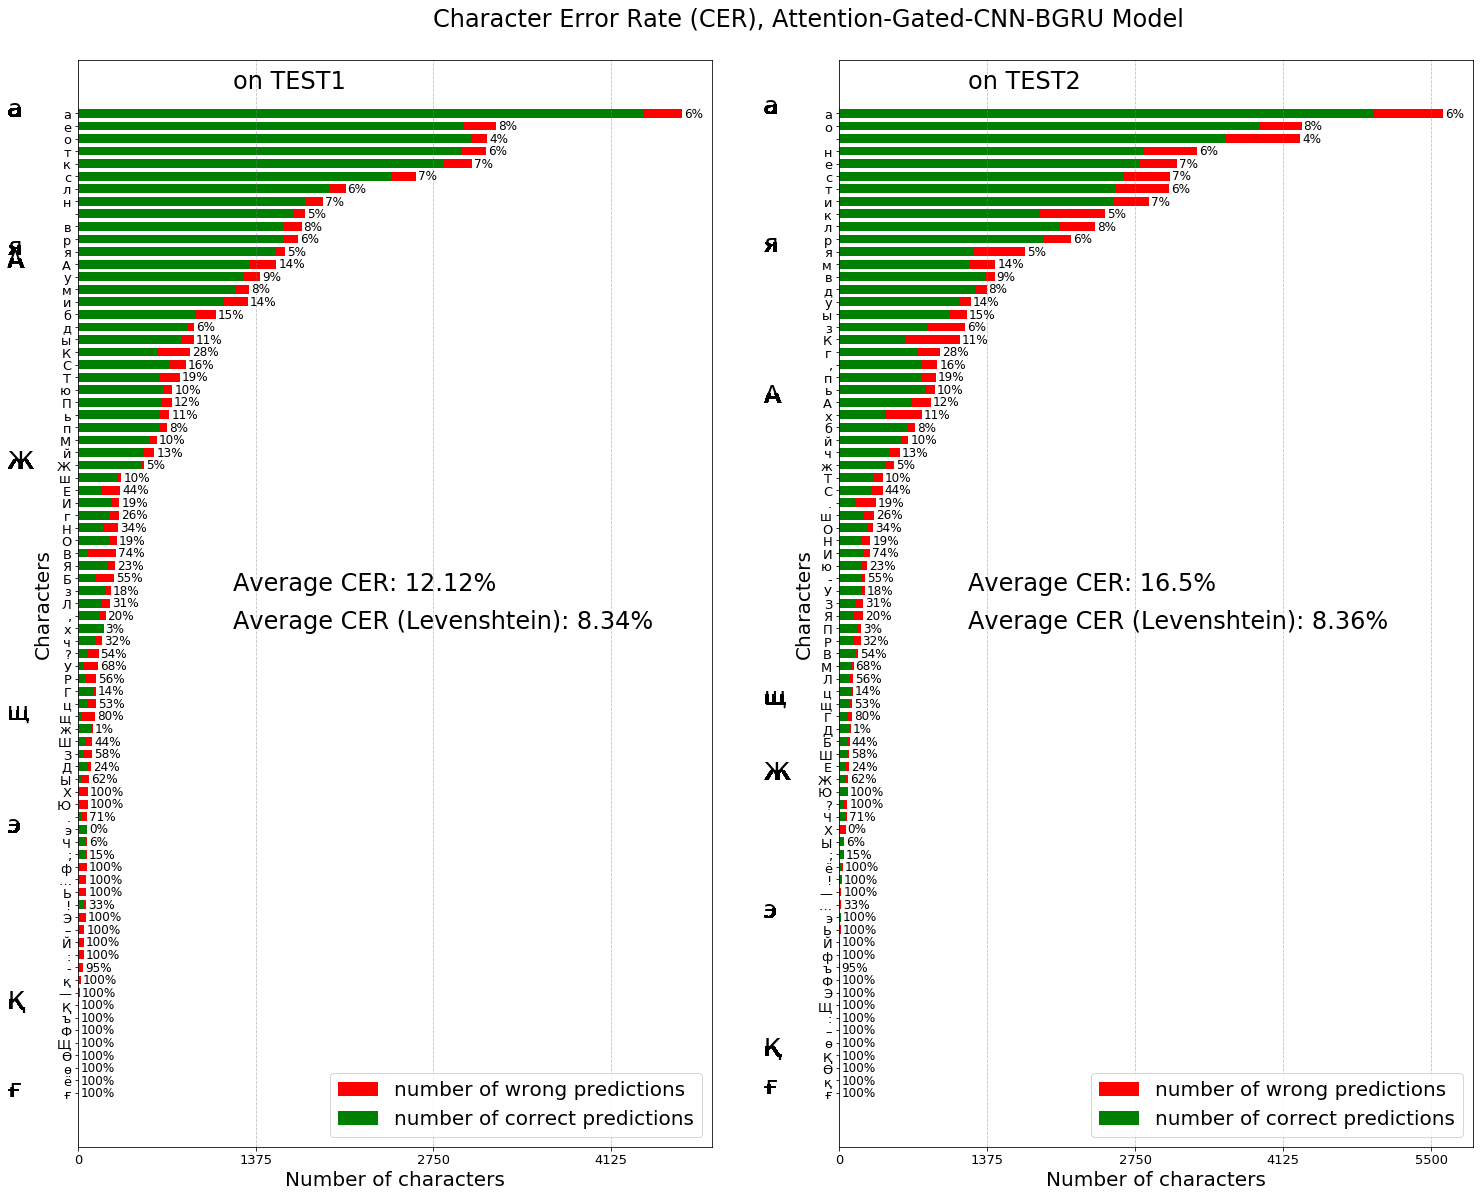

In [112]:
# Plot figures
import matplotlib.pyplot as plt

test1_symbols_freq = [x['freq'] for x in test1_symbols.values()]
test1_symbols_pred = [x['pred'] for x in test1_symbols.values()]
test1_symbols_acc = [x['acc'] for x in test1_symbols.values()]
test1_symbols_err = [x['err'] for x in test1_symbols.values()]
test2_symbols_freq = [x['freq'] for x in test2_symbols.values()]
test2_symbols_pred = [x['pred'] for x in test2_symbols.values()]
test2_symbols_acc = [x['acc'] for x in test2_symbols.values()]
test2_symbols_err = [x['err'] for x in test1_symbols.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20), sharey=False)
ax1.text(2750, 85, "Character Error Rate (CER), " + model_name, fontsize=24)

#AX1 axis
ax1.text(1200, 80, "on TEST1", fontsize=24)
ax1.text(1200, 40, "Average CER: " + str(test1_CER) + "%", fontsize=24)
ax1.text(1200, 37, "Average CER (Levenshtein): " + str(test1_CER_Lev) + "%", fontsize=24)
width = 0.7
plt.rcParams['font.size'] = 12
ax1.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
ax1.set_xticks(np.linspace(0, 5500, 5))
ax1.set_xlabel('Number of characters', fontsize = 20)
ax1.set_ylabel('Characters', fontsize = 20)
rects = ax1.barh(list(test1_symbols.keys()), test1_symbols_freq, width, color = 'r', log = False, label='number of wrong predictions')
rects_acc = ax1.barh(list(test1_symbols.keys()), test1_symbols_pred, width, color = 'g', log = False, label='number of correct predictions')
ax1.legend(loc="lower right", fontsize = 20)
for i, rect in enumerate(rects):
    yloc = rect.get_y() + rect.get_height() / 2
    xloc = -5
    width = int(rect.get_width())
    # The bars aren't wide enough to print the ranking inside
    if width < 999999:
        # Shift the text to the right side of the right edge
        xloc = 2
        # Black against white background
        clr = 'black'
        align = 'left'
    else:
        # Shift the text to the left side of the right edge
        xloc = -5
        # White on magenta
        clr = 'white'
        align = 'right'
    label = ax1.annotate(str(test1_symbols_err[i])+'%', xy=(width, yloc), xytext=(xloc, 0),
                            textcoords="offset points",
                            ha=align, va='center',
                            color=clr, clip_on=True, fontsize=12)
    for i in range(len(test1_symbols_freq)):
        if list(test1_symbols.keys())[i] in ['а','я', 'А', 'Ж','щ','э','Қ','ғ']:
            ax1.text(-550 , i-0.25, str(list(test1_symbols.keys())[i]), color='black', fontsize='24')
  

# AX2 axis
ax2.text(1200, 80, "on TEST2", fontsize=24)
ax2.text(1200, 40, "Average CER: " + str(test2_CER) + "%", fontsize=24)
ax2.text(1200, 37, "Average CER (Levenshtein): " + str(test2_CER_Lev) + "%", fontsize=24)
width = 0.7
plt.rcParams['font.size'] = 13
ax2.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
ax2.set_xticks(np.linspace(0, 5500, 5))
ax2.set_xlabel('Number of characters', fontsize = 20)
ax2.set_ylabel('Characters', fontsize = 20)
rects = ax2.barh(list(test2_symbols.keys()), test2_symbols_freq, width, color = 'r', log = False, label='number of wrong predictions')
rects_acc = ax2.barh(list(test2_symbols.keys()), test2_symbols_pred, width, color = 'g', log = False, label='number of correct predictions')
ax2.legend(loc="lower right", fontsize = 20)
for i, rect in enumerate(rects):
    yloc = rect.get_y() + rect.get_height() / 2
    xloc = -5
    width = int(rect.get_width())
    # The bars aren't wide enough to print the ranking inside
    if width < 999999:
        # Shift the text to the right side of the right edge
        xloc = 2
        # Black against white background
        clr = 'black'
        align = 'left'
    else:
        # Shift the text to the left side of the right edge
        xloc = -5
        # White on magenta
        clr = 'white'
        align = 'right'
    label = ax2.annotate(str(test2_symbols_err[i])+'%', xy=(width, yloc), xytext=(xloc, 0),
                            textcoords="offset points",
                            ha=align, va='center',
                            color=clr, clip_on=True, fontsize=12)
    for i in range(len(test2_symbols_freq)):
        if list(test2_symbols.keys())[i] in ['а','я', 'А', 'Ж','щ','э','Қ','ғ']:
            ax2.text(-700 , i, str(list(test2_symbols.keys())[i]), color='black', fontsize='24')
    
#plt.show()
plt.savefig('CER_'+model_name+'.png', size=6, transparent=False, bbox_inches='tight', pad_inches=0, dpi=300)